# Fonctions pour le calcul avec le maximum de la vraisemblance

## Lecture et nettoyage des données (code fourni)

In [2]:
using CSV, DataFrames, Gadfly, Distributions, StatsBase, GaussianMixtures

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\antoi\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228
┌ Info: Precompiling GaussianMixtures [cc18c42c-b769-54ff-9e2a-b28141a64aae]
└ @ Base loading.jl:1192


In [3]:
train = CSV.read("ODtrain.csv")
n = size(train,1)
p = size(train,2)
dropmissing!(train, disallowmissing=true)
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"]

d = Array{String}(undef,n)

for i=1:length(str_mode)
   
    ind = train[:D_Mode] .== i
    d[ind] .= str_mode[i] 
    
end

train[:D_Mode_str] = d

categorical!(train, :D_Mode_str);

## Analyse des distributions des données

Ici on peut changer les valeurs des trois premières variables pour tenter de trouver la bonne distribution à associer à une variable quelconque.

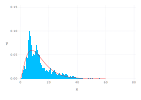

In [4]:
dep = 2;
sym = :M_dist_centre
dist = Gamma

voi = train[train[:D_Mode] .== dep, :];
fd = fit_mle(dist, voi[sym]);
xx = 0:0.1:60;
f = pdf.(fd, xx);
h = layer(x = voi[sym], Geom.histogram(density = true));
f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
plot(f, h)

## Fonctions pour le calcul

### Constante

In [5]:
k = 5

5

### Déclaration de types utilisés

In [6]:
struct MelangeNormales
    n::Int64
end

### Fonctions internes ("privées")

In [7]:
function determineMode(index::Int64, dist::Array{Distribution, 2}, columns::Array{Symbol, 1}, testSet::DataFrame)
    # Y Cat(τ)
    τ = fit(Categorical, train[:D_Mode])
    # P(Y = i | X = dist) = p[i]
    p = Array{Float64}(undef, k)
    max = 1
    for i=1:k
        p[i] = log(pdf(τ, i))
        nVarExpl = size(dist, 1)
        for j=1:nVarExpl
           p[i] += log(pdf(dist[j, i], testSet[columns[j]][index]))
        end
        if p[max] < p[i]
            max = i
        end
    end
    return max
end
function validate(estimates::Array{Int64}, realValue::Array{Int64})
    n = length(realValue)
    nEach = [0, 0, 0, 0, 0]
    right = [0, 0, 0, 0, 0]
    for i=1:n
        nEach[realValue[i]] += 1
        if estimates[i] == realValue[i]
            right[realValue[i]] += 1
        end
    end
    for i=1:k
       print(str_mode[i], " : ", right[i]/nEach[i]*100, "%\n" ) 
    end
    print("Total : ", sum(right)/n*100, "%\n" ) 
end
struct TestSet
    train::DataFrame
    test::DataFrame
end
function getTestSet(initialSet::DataFrame)
    n = length(initialSet[:D_Mode])
    nTest = convert(Int64, round(0.20 * n))
    index = rand(0:n-nTest+1)
    return TestSet(vcat(initialSet[1:index-1, :], initialSet[index+nTest:n, :]), initialSet[index:index+nTest-1, :])
    
    a = [1,2,3]
    b= view(a, 1:2)
    c= vcat(view(a, 1:1), view(a, 3:3))
end
function getEstimation(distType::Array{Any, 2}, columns::Array{Symbol, 1}, set::TestSet)
    # Maximum de la vraisemblance pour estimer
    nVariablesExpl = length(columns)
    dist = Array{Distribution}(undef, nVariablesExpl, k)
    for varExpl=1:nVariablesExpl
        for mode=1:k
            trainT = set.train[set.train[:D_Mode] .== mode, :];
            if typeof(distType[varExpl, mode]) == MelangeNormales
                gmm = GMM(distType[varExpl, mode].n, trainT[Symbol(columns[varExpl])]; method=:kmeans, nInit=100, nIter=20)
                dist[varExpl, mode] = MixtureModel(gmm)
            else
                # fit_mle retourne les estimateurs avec le maximum de la vraisemblance.
                dist[varExpl, mode] = fit_mle(distType[varExpl, mode], trainT[Symbol(columns[varExpl])])
            end
        end
    end
    amount = length(set.test[:IPERE])
    res= Array{Int64}(undef, amount)
    for i=1:amount
       res[i] = determineMode(i, dist, columns, set.test) 
    end
    return res
end

getEstimation (generic function with 1 method)

### Fonction "publique"

In [8]:
function getPercentRight(distType::Array{Any, 2}, columns::Array{Symbol, 1})
    set = getTestSet(train)
    estimation = getEstimation(distType, columns, set)
    validate(estimation, set.test[:D_Mode])
end
function generateSubmission(distType::Array{Any, 2}, columns::Array{Symbol, 1})
    test = CSV.read("ODtest.csv")
    submission = test[:, [:IPERE]]
    set = TestSet(train, test)
    estimation = getEstimation(distType, columns, set)
    submission = DataFrame(IPERE = test[:IPERE],D_MODE = estimation)
    CSV.write("Submission.csv", submission)
end

generateSubmission (generic function with 1 method)

### Exemple

Ici, on estime que la variable P_PERMIS est distribuée selon une loi Catégorielle.
On pense la même chose pour la variable P_STATUT.
Pour la variable M_dist_centre, on pense plutôt qu'elle suit une loi Gamma.

Pour les trois variables, nous avons donné la même distribution peut-importe la valeur de Y.
Cependant, si nous pensions que lorsque Y = 3, la variable M_dist_centre est distribuée selon une loi normale, nous aurions pu écrire:
Gamma Gamma Normal Gamma Gamma

Les fonctions ci-dessus séparent l'échantillon train en deux portions (4/5 train, 1/5 test). Cette séparation change à toutes les fois où l'algorithme est roulé.
Le résultat de l'appel à getPercentRight est séparé selon le mode de transport.

In [12]:
getPercentRight([
        [Categorical Categorical Categorical Categorical Categorical];
        [Categorical Categorical Categorical Categorical Categorical];
        [MelangeNormales(10) MelangeNormales(7) MelangeNormales(7) MelangeNormales(8) MelangeNormales(9)];
        #[MelangeNormales(20) MelangeNormales(15) MelangeNormales(15) MelangeNormales(16) MelangeNormales(17)];
        [Poisson Poisson Poisson Poisson Poisson]
        ], [
        :P_PERMIS,
        :P_STATUT,
        :M_dist_centre,
        :M_AUTO
        ])

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.973305e+04
      1       2.976997e+04      -1.996308e+04 |       10
      2       2.726926e+04      -2.500712e+03 |       10
      3       2.662431e+04      -6.449545e+02 |       10
      4       2.635514e+0

┌ Info: Initializing GMM, 10 Gaussians LinearAlgebra.diag covariance 1 dimensions using 28671 data points
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:77


4      -2.691676e+02 |       10
      5       2.620378e+04      -1.513542e+02 |        8
      6       2.606820e+04      -1.355844e+02 |        8
      7       2.596688e+04      -1.013188e+02 |        8
      8       2.587773e+04      -8.915022e+01 |        8
      9       2.581840e+04      -5.932899e+01 |        8
     10       2.576484e+04      -5.356290e+01 |        8
     11       2.572507e+04      -3.976903e+01 |        9
     12       2.569759e+04      -2.747818e+01 |        8
     13       2.567805e+04      -1.954524e+01 |        9
     14       2.566573e+04      -1.231161e+01 |        7
     15       2.565361e+04      -1.212822e+01 |        8
     16       2.564108e+04      -1.252481e+01 |        6
     17       2.562495e+04      -1.613521e+01 |        5
     18       2.560957e+04      -1.537754e+01 |        5
     19       2.559800e+04      -1.156804e+01 |        5
     20       2.558646e+04      -1.154027e+01 |        6
     21       2.556963e+04      -1.682997e+01 |        6

┌ Info: K-means with 10000 data points using 40 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 10 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.887724
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.865343
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.858927
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.856003
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.854373
└ @ Gaussi

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0  

┌ Info: iteration 13, average log likelihood -3.850746
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 14, average log likelihood -3.850569
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.850408
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.850259
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.850122
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.849996
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.849879
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\

     3.982701e+04
      1       2.615199e+04      -1.367503e+04 |        7
      2       2.426901e+04      -1.882973e+03 |        7
      3       2.327878e+04      -9.902364e+02 |        7
      4       2.270597e+04      -5.728093e+02 |        6
      5       2.211491e+04      -5.910550e+02 |        7
      6       2.162059e+04      -4.943253e+02 |        7
      7       2.136509e+04      -2.554965e+02 |        7
      8       2.119574e+04      -1.693553e+02 |        7
      9       2.106177e+04      -1.339610e+02 |        7
     10       2.091522e+04      -1.465503e+02 |        7
     11       2.074451e+04      -1.707185e+02 |        7
     12       2.058021e+04      -1.642936e+02 |        7
     13       2.038250e+04      -1.977160e+02 |        7
     14       2.015509e+04      -2.274064e+02 |        7
     15       2.001780e+04      -1.372871e+02 |        7
     16       1.992979e+04      -8.801251e+01 |        7
     17       1.983897e+04      -9.082361e+01 |        7
     18      

┌ Info: K-means with 7000 data points using 67 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.372395
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.345919
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.338258
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.334761
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.332791
└ @ Gaussian

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.134445e+04
      1       6.407702e+03      -4.936746e+03 |        6
      2       6.056532e+03      -3.511700e+02 |        6
      3       5.939511e+03      -1.170203e+02 |        6
    

┌ Info: iteration 13, average log likelihood -3.327982
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 14, average log likelihood -3.327708
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.327455
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.327219
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.326997
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.326789
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.326593
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\

  4       5.869298e+03      -7.021345e+01 |        6
      5       5.807249e+03      -6.204889e+01 |        6
      6       5.758260e+03      -4.898928e+01 |        6
      7       5.729066e+03      -2.919358e+01 |        6
      8       5.699263e+03      -2.980368e+01 |        6
      9       5.685988e+03      -1.327497e+01 |        6
     10       5.678831e+03      -7.157114e+00 |        5
     11       5.677315e+03      -1.515237e+00 |        3
     12       5.676081e+03      -1.233866e+00 |        4
     13       5.675770e+03      -3.118266e-01 |        0
     14       5.675770e+03       0.000000e+00 |        0
K-means converged with 14 iterations (objv = 5675.769571401662)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.940033e+04
      1       2.143673e+04      -7.963598e+03 |        8
      2       2.060856e+04      -8.281696e+02 |        7
      3 

┌ Info: K-means with 1658 data points using 14 iterations
│ 118.4 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.685263
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.666980
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.662146
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.660141
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.659100
└ @ Gaussian

      1.999209e+04      -6.164720e+02 |        7
      4       1.932357e+04      -6.685169e+02 |        7
      5       1.861155e+04      -7.120275e+02 |        7
      6       1.822652e+04      -3.850237e+02 |        7
      7       1.797969e+04      -2.468376e+02 |        7
      8       1.784216e+04      -1.375294e+02 |        7
      9       1.775128e+04      -9.087858e+01 |        7
     10       1.768194e+04      -6.933762e+01 |        7
     11       1.764957e+04      -3.237482e+01 |        7
     12       1.763529e+04      -1.427479e+01 |        7
     13       1.761995e+04      -1.533638e+01 |        7
     14       1.761302e+04      -6.930321e+00 |        7
     15       1.760886e+04      -4.167300e+00 |        7
     16       1.760186e+04      -6.993816e+00 |        7
     17       1.759599e+04      -5.869431e+00 |        7
     18       1.758940e+04      -6.588673e+00 |        6
     19       1.758541e+04      -3.995664e+00 |        4
     20       1.758407e+04      -1.3395

┌ Info: K-means with 6940 data points using 23 iterations
│ 433.8 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 8 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.586955
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.569521
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.565095
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.563278
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.562318
└ @ Gaussian

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.823423e+04
      1       1.547046e+04      -2.763772e+03 |        8
      2       1.456954e+04      -9.009200e+02 |        9


┌ Info: iteration 14, average log likelihood -3.559737
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.559591
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.559456
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.559330
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.559213
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.559103
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -3.559001
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\

      3       1.417924e+04      -3.903053e+02 |        9
      4       1.403076e+04      -1.484728e+02 |        9
      5       1.395003e+04      -8.072839e+01 |        8
      6       1.391608e+04      -3.395072e+01 |        7
      7       1.389385e+04      -2.223767e+01 |        8
      8       1.387882e+04      -1.502383e+01 |        9
      9       1.386589e+04      -1.293200e+01 |        7
     10       1.385892e+04      -6.968435e+00 |        6
     11       1.384830e+04      -1.062552e+01 |        6
     12       1.383228e+04      -1.602055e+01 |        7
     13       1.382321e+04      -9.070279e+00 |        7
     14       1.382121e+04      -1.995485e+00 |        4
     15       1.381747e+04      -3.742745e+00 |        2
     16       1.381237e+04      -5.093126e+00 |        3
     17       1.380627e+04      -6.104902e+00 |        5
     18       1.379988e+04      -6.386649e+00 |        4
     19       1.379907e+04      -8.118293e-01 |        2
     20       1.379866e+04     

┌ Info: K-means with 4040 data points using 24 iterations
│ 224.4 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 9 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.929462
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.908970
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.902996
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.900427
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.899115
└ @ Gaussian

Voiture : 80.47754714421382%
Transport Collectif : 44.785276073619634%
Hybride : 0.0%
Actif : 30.721220527045766%
Autre : 78.23639774859286%
Total : 64.3002640513014%


In [13]:
generateSubmission([
        [Categorical Categorical Categorical Categorical Categorical];
        [Categorical Categorical Categorical Categorical Categorical];
        [MelangeNormales(10) MelangeNormales(7) MelangeNormales(7) MelangeNormales(8) MelangeNormales(9)];
        #[MelangeNormales(20) MelangeNormales(15) MelangeNormales(15) MelangeNormales(16) MelangeNormales(17)];
        [Poisson Poisson Poisson Poisson Poisson]
        ], [
        :P_PERMIS,
        :P_STATUT,
        :M_dist_centre,
        :M_AUTO
        ])

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       5.698512e+04
      1       3.617536e+04      -2.080976e+04 |        9
      2       3.392875e+04      -2.246607e+03 |       10
      3       3.314486e+04      -7.838904e+02 |       10
      4   

┌ Info: Initializing GMM, 10 Gaussians LinearAlgebra.diag covariance 1 dimensions using 36042 data points
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:77


    3.259428e+04      -5.505819e+02 |       10
      5       3.210571e+04      -4.885713e+02 |       10
      6       3.164568e+04      -4.600294e+02 |        9
      7       3.124064e+04      -4.050406e+02 |       10
      8       3.088644e+04      -3.542014e+02 |       10
      9       3.060182e+04      -2.846118e+02 |       10
     10       3.035240e+04      -2.494292e+02 |       10
     11       3.020473e+04      -1.476645e+02 |       10
     12       3.010692e+04      -9.780770e+01 |       10
     13       3.002829e+04      -7.863270e+01 |       10
     14       2.996839e+04      -5.990387e+01 |       10
     15       2.991153e+04      -5.685889e+01 |       10
     16       2.985295e+04      -5.858115e+01 |        9
     17       2.976891e+04      -8.404046e+01 |       10
     18       2.965014e+04      -1.187695e+02 |       10
     19       2.952617e+04      -1.239673e+02 |       10
     20       2.939786e+04      -1.283075e+02 |       10
     21       2.921252e+04      -1.853392

┌ Info: K-means with 10000 data points using 46 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 10 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.885257
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.862460
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.856434
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.853832
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.852437
└ @ Gaussi

  Iters               objv        objv-change | affected 


┌ Info: iteration 15, average log likelihood -3.849383
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.849290
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.849204
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.849122
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 19, average log likelihood -3.849044
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 20, average log likelihood -3.848968
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: EM with 36042 data points 20 iterations avll -3.848968
│ 1242.8 data points per parameter
└ @ GaussianMixtures C:\Users\an

-------------------------------------------------------------
      0       3.415849e+04
      1       2.168846e+04      -1.247003e+04 |        7
      2       2.021879e+04      -1.469666e+03 |        7
      3       1.947791e+04      -7.408789e+02 |        6
      4       1.906856e+04      -4.093499e+02 |        7
      5       1.883643e+04      -2.321322e+02 |        7
      6       1.866521e+04      -1.712246e+02 |        7
      7       1.857453e+04      -9.067425e+01 |        7
      8       1.852957e+04      -4.495986e+01 |        7
      9       1.849953e+04      -3.003665e+01 |        7
     10       1.847315e+04      -2.638273e+01 |        7
     11       1.845350e+04      -1.965176e+01 |        7
     12       1.844139e+04      -1.210941e+01 |        7
     13       1.843514e+04      -6.254734e+00 |        7
     14       1.842956e+04      -5.577210e+00 |        7
     15       1.842093e+04      -8.627109e+00 |        7
     16       1.841284e+04      -8.095886e+00 |        5

┌ Info: K-means with 7000 data points using 49 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.357281
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.334610
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.328418
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.325677
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.324158
└ @ Gaussian

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.080245e+04
      1       8.089464e+03      -2.712982e+03 |        6


┌ Info: iteration 12, average log likelihood -3.320563
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 13, average log likelihood -3.320301
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 14, average log likelihood -3.320061
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 15, average log likelihood -3.319838
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 16, average log likelihood -3.319630
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 17, average log likelihood -3.319437
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 18, average log likelihood -3.319256
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\

      2       7.889482e+03      -1.999818e+02 |        7
      3       7.715313e+03      -1.741693e+02 |        7
      4       7.573837e+03      -1.414762e+02 |        5
      5       7.499464e+03      -7.437323e+01 |        5
      6       7.453002e+03      -4.646152e+01 |        6
      7       7.427496e+03      -2.550648e+01 |        6
      8       7.394963e+03      -3.253217e+01 |        6
      9       7.369351e+03      -2.561257e+01 |        5
     10       7.359047e+03      -1.030430e+01 |        5
     11       7.354151e+03      -4.895182e+00 |        5
     12       7.349510e+03      -4.641716e+00 |        3
     13       7.346395e+03      -3.114726e+00 |        5
     14       7.341879e+03      -4.516059e+00 |        4
     15       7.336504e+03      -5.375145e+00 |        5
     16       7.335135e+03      -1.368647e+00 |        5
     17       7.331312e+03      -3.823061e+00 |        4
     18       7.322143e+03      -9.168814e+00 |        4
     19       7.315056e+03     

┌ Info: K-means with 2100 data points using 24 iterations
│ 150.0 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 7 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.701135
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.681990
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.676839
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.674670
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.673537
└ @ Gaussian

4       2.023847e+04      -1.533672e+02 |        7
      5       2.018507e+04      -5.339932e+01 |        7
      6       2.016834e+04      -1.673022e+01 |        7
      7       2.013878e+04      -2.955657e+01 |        7
      8       2.010828e+04      -3.050198e+01 |        7
      9       2.009366e+04      -1.461715e+01 |        7
     10       2.008370e+04      -9.966656e+00 |        8
     11       2.007644e+04      -7.254819e+00 |        7
     12       2.007219e+04      -4.256583e+00 |        7
     13       2.007050e+04      -1.689772e+00 |        6
     14       2.006986e+04      -6.358415e-01 |        6
     15       2.006965e+04      -2.099093e-01 |        2
     16       2.006964e+04      -9.141364e-03 |        2
     17       2.006962e+04      -2.569325e-02 |        2
     18       2.006961e+04      -3.492422e-03 |        0
     19       2.006961e+04       0.000000e+00 |        0
K-means converged with 19 iterations (objv = 20069.61283053075)


┌ Info: K-means with 8000 data points using 19 iterations
│ 500.0 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 8 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.582859
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.603859e+04
      1    

┌ Info: iteration 2, average log likelihood -3.565377
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.561019
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.559270
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.558370
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 6, average log likelihood -3.557823
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 7, average log likelihood -3.557444
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 8, average log likelihood -3.557155
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmm

   2.095595e+04      -5.082642e+03 |        9
      2       2.013459e+04      -8.213574e+02 |        8
      3       1.992155e+04      -2.130387e+02 |        8
      4       1.985042e+04      -7.113259e+01 |        9
      5       1.980773e+04      -4.269586e+01 |        8
      6       1.974900e+04      -5.872605e+01 |        6
      7       1.970888e+04      -4.011529e+01 |        6
      8       1.968825e+04      -2.063091e+01 |        6
      9       1.967203e+04      -1.622451e+01 |        6
     10       1.966006e+04      -1.197247e+01 |        6
     11       1.965289e+04      -7.161947e+00 |        7
     12       1.964002e+04      -1.287304e+01 |        7
     13       1.961290e+04      -2.712169e+01 |        6
     14       1.955612e+04      -5.677626e+01 |        5
     15       1.944088e+04      -1.152438e+02 |        6
     16       1.935167e+04      -8.920507e+01 |        7
     17       1.927532e+04      -7.635783e+01 |        6
     18       1.921776e+04      -5.755776e

┌ Info: K-means with 5106 data points using 93 iterations
│ 283.7 data points per parameter
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:138
┌ Info: Running 20 iterations EM on diag cov GMM with 9 Gaussians in 1 dimensions
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\train.jl:242
┌ Info: iteration 1, average log likelihood -3.931830
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 2, average log likelihood -3.911536
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 3, average log likelihood -3.905965
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 4, average log likelihood -3.903556
└ @ GaussianMixtures C:\Users\antoi\.julia\packages\GaussianMixtures\RGtTJ\src\gmms.jl:71
┌ Info: iteration 5, average log likelihood -3.902270
└ @ Gaussian

"Submission.csv"